In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
#torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

1.7.0 0.8.1


In [2]:
#dst = datasets.CIFAR100("~/.torch", download=True)
dst = datasets.FashionMNIST("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Running on cuda:0


In [3]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.3, 0.3)
#     if hasattr(m, "bias"):
#         m.bias.data.uniform_(-0.3, 0.3)    

# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 20, 5, 1)
#         self.conv2 = nn.Conv2d(20, 50, 5, 1)
#         self.fc1 = nn.Linear(4 * 4 * 50, 500)
#         self.fc2 = nn.Linear(500, 10)
#     def forward(self, x):
#         #x = F.relu(self.conv1(x))
#         x = F.sigmoid(self.conv1(x))
#         #x = F.tanh(self.conv1(x))
#         x = F.max_pool2d(x, 2, 2)
#         #x = F.relu(self.conv2(x))
#         x = F.sigmoid(self.conv2(x))
#         #x = F.tanh(self.conv2(x))
#         x = F.max_pool2d(x, 2, 2)
#         x = x.view(-1, 4 * 4 * 50)
#         #x = F.relu(self.fc1(x))
#         x = F.sigmoid(self.fc1(x))
#         #x = F.tanh(self.fc1(x))
#         x = self.fc2(x)
#         return x

#     def name(self):
#         return "LeNet"


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        #act = nn.Tanh
        #act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(588, 10)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out




net = LeNet().to(device)
net.apply(weights_init)




    
#net.apply(weights_init)
#criterion = cross_entropy_for_onehot
criterion = nn.CrossEntropyLoss()

In [4]:
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
train_tp = transforms.Compose([
     transforms.Resize(28),
     transforms.CenterCrop(28),
#    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]),
    transforms.ToTensor()
])
training = datasets.FashionMNIST("~/.torch",train=True, download=True,transform=train_tp)





def sgd_update(parameters):
    for param in parameters:
        param.data = param.data - 0.01 * param.grad.data #+ torch.empty(param.data.size()).normal_(mean=0,std=0.001).to(device)


criterion_train = nn.CrossEntropyLoss()
optimizer_train = optim.Adam(net.parameters(),lr=0.01)#,momentum=0.9)
trainloader = torch.utils.data.DataLoader(training,batch_size=64, shuffle=False)
for epoch in range(0):

    for i,data in enumerate(trainloader,0):
    #for data in trainloader:
        #if i<=10: 

            inputs,label = data

            inputs,label =  Variable(inputs).to(device),Variable(label).to(device)

            optimizer_train.zero_grad()
            outputs_benign=net(inputs)

            loss_benign =  criterion_train(outputs_benign,label)

            loss_benign.backward()
            #sgd_update(net.parameters())

            optimizer_train.step()
            
            testing = datasets.MNIST("~/.torch",train=False, download=True,transform=train_tp)
            testloader = torch.utils.data.DataLoader(testing,batch_size=1000, shuffle=False)

            acc =0.0
            for ji,tdata in enumerate(testloader,0):

                tinputs,tlabel = tdata

                tinputs,tlabel =  Variable(tinputs).to(device),Variable(tlabel).to(device)

                toutputs=net(tinputs)

                tpredict = torch.argmax(toutputs, dim=1)


                for mi in range(1000):



                    if tpredict[mi] == tlabel[mi]:
                        acc=acc+1

            accuracy = acc / 10000
            print (accuracy)
            print ('fininshed testing')
            if accuracy>0.18:
                break


print ('fininshed training')
#torch.save(net.state_dict())

testing = datasets.MNIST("~/.torch",train=False, download=True,transform=train_tp)
testloader = torch.utils.data.DataLoader(testing,batch_size=1000, shuffle=False)

acc =0.0
for ji,tdata in enumerate(testloader,0):

    tinputs,tlabel = tdata

    tinputs,tlabel =  Variable(tinputs).to(device),Variable(tlabel).to(device)

    toutputs=net(tinputs)
    
    tpredict = torch.argmax(toutputs, dim=1)
    
   
    for mi in range(1000):
        
        

        if tpredict[mi] == tlabel[mi]:
            acc=acc+1

accuracy = acc / 10000
print (accuracy)
print ('fininshed testing')



fininshed training
0.1028
fininshed testing


now starting 20000
stolen label is 4.
30
0.08808721601963043


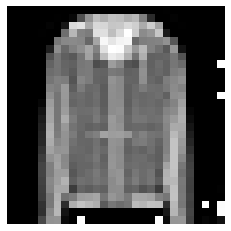

In [5]:
from pytorch_msssim import ssim

#dgc_rate_list = [10,50,75,100,150,250,500,750,1000,2000]
#for epoch in range(1):

#dgc_rate_list = [0,1,10,20,30,40,50]
dgc_rate_list = [20000]




for dgc_rate in dgc_rate_list:
    
    print('now starting',dgc_rate)

    for iter_,data in enumerate(trainloader,1):
        if iter_ == 1: 
   
            ######### honest partipant #########
            img_index = 28
            gt_data = tp(dst[img_index][0]).to(device)
            gt_data = gt_data.view(1, *gt_data.size())
            gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
            gt_label = gt_label.view(1, )
            gt_onehot_label = label_to_onehot(gt_label, num_classes=10)


            batch =1  #
            for bat in range(batch-1):
                tmp = torch.unsqueeze(tp(dst[img_index+1+bat][0]).to(device),0)
                #print(tmp.shape)
                gt_data = torch.cat((gt_data,tmp),0)

                gt_label_tmp = torch.Tensor([dst[img_index+1+bat][1]]).long().to(device) #use img_index

                gt_label_tmp = gt_label_tmp.view(1, )
                gt_label = torch.cat((gt_label,gt_label_tmp),0)
                gt_onehot_label = torch.cat((gt_onehot_label,label_to_onehot(gt_label_tmp, num_classes=10)),0)


                #plt.savefig("./original/index_%s_label_%s"%(bat+1,gt_label_tmp.item()))

                #plt.title("Ground truth image")
                #print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())


            gt_label = torch.reshape(gt_label,(-1,1))    
            #print (gt_data.shape)
            #print (gt_label.shape)
            #print (gt_onehot_label.shape)

            plt.imshow(tt(gt_data[0].cpu()),cmap='gray')
            plt.axis('off')
            plt.savefig("./attack_image/CVPR/fashionmnist_gt")
            #plt.title("Ground truth image")
            #print("GT label is %d." % gt_label[0].item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label[0], dim=-1).item())

            # compute original gradient 
            dy_dx = []
            original_dy_dx=[]
            for item in range(batch):
                gt_data_single = torch.unsqueeze(gt_data[item],0)
                out = net(gt_data_single)

                #y = criterion(out, gt_onehot_label[item])
                y = criterion(out, gt_label[item])

                dy_dx = torch.autograd.grad(y, net.parameters())


                original_dy_dx_tmp = list((_.detach().clone() for _ in dy_dx))
                original_dy_dx.append(original_dy_dx_tmp)


#             #if gaussian noise or laplace
#             #m = torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([0.0001]))
#             #print  (original_dy_dx[0][0][0])
#             for item in range(batch):
#                for layer_idx in range(10):
#                     original_dy_dx[item][layer_idx] =  original_dy_dx[item][layer_idx] + torch.empty(original_dy_dx[item][layer_idx].size()).normal_(mean=0,std=1/dgc_rate).to(device)
#                     #original_dy_dx[item][layer_idx] =  original_dy_dx[item][layer_idx] + torch.squeeze(m.sample(sample_shape=original_dy_dx[item][layer_idx].size()),dim=-1).to(device)
#             #print  (original_dy_dx[0][0][0])
#             #print ('!!!')
#             #if deep gradient compression
#             #print (original_dy_dx[0][0][0])
#             for item in range(batch):
#                 for layer_idx in range(10):
#                     if layer_idx == 0:    
#                         flat_dy_dx = torch.flatten(original_dy_dx[item][layer_idx])
#                     else:
#                         flat_dy_dx = torch.cat((flat_dy_dx,torch.flatten(original_dy_dx[item][layer_idx])),0)
#             sorted_dy_dx = flat_dy_dx.abs().sort()
#             size = np.asarray(list(flat_dy_dx.shape))
#             thresh = sorted_dy_dx[0][int(size * dgc_rate/100.0)]
#             for item in range(batch):
#                 for layer_idx in range(10):
#                     shape_tmp = original_dy_dx[item][layer_idx].size()
#                     flat_dy_dx_prune = torch.flatten(original_dy_dx[item][layer_idx])
#                     size_tmp = np.asarray(list(flat_dy_dx_prune.shape))
#                     for m in range(int(size_tmp)):
#                         if flat_dy_dx_prune[m].abs()<=thresh:
#                             flat_dy_dx_prune[m] = 0
#                     original_dy_dx[item][layer_idx] = flat_dy_dx_prune.view(shape_tmp)
#             for item in range(batch):
#                 for layer_idx in range(10):
#                     original_dy_dx[item][layer_idx] =  original_dy_dx[item][layer_idx] + torch.empty(original_dy_dx[item][layer_idx].size()).normal_(mean=0,std=1/980).to(device)
#             #print (original_dy_dx[0][0][0])




            # generate dummy data and label
            import time

            #if iter_ % 10 ==0: 
            #if iter_ == 0:

            #print ('epoch',epoch,'iter',iter_)
            for item in range(1):
                start = time.time()
                for rd in range(1):

                    #torch.manual_seed(100*rd)

                    pat_1 = torch.rand([1,14,14])
                    pat_2 = torch.cat((pat_1,pat_1),dim=1)
                    pat_4 = torch.cat((pat_2,pat_2),dim=2)
                    dummy_data = torch.unsqueeze(pat_4,dim=0).to(device).requires_grad_(True)
                    
                    #dummy_data = torch.rand([1,1,28,28]).to(device).requires_grad_(True)


                    dummy_unsqueeze=torch.unsqueeze(gt_onehot_label[item],dim=0)

                    dummy_label = torch.randn(gt_onehot_label[item].size()).to(device).requires_grad_(True)
                    label_pred = torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)
                    label_pred_onehot = label_to_onehot(label_pred, num_classes=10)

                    plt.imshow(tt(dummy_data[0].cpu()))
                    plt.title("Dummy data")
                    #plt.savefig("./random_seed/index_%s_rand_seed_%s_label_%s"%(item,rd,torch.argmax(dummy_label, dim=-1).item()))

                    plt.clf()
                    #print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
                    print("stolen label is %d." % label_pred.item())

                    #optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
                    optimizer = torch.optim.LBFGS([dummy_data,])


                    history = []
                    history_batch = []
                    history_grad = []

                    percept_dis = np.zeros(300)
                    recover_dis = np.zeros(300)
                    for iters in range(300):

                        percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[item],dim=0),data_range=0).item()
                        recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()

                        history.append(tt(dummy_data[0].cpu()))

                        def closure():
                            optimizer.zero_grad()

                            pred = net(dummy_data) 
                            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
                            #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.

                            #dummy_loss = criterion(pred, label_pred_onehot)
                            dummy_loss = criterion(pred, label_pred)


                            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                            #dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                            #print (dummy_dy_dp[0].shape)

                            grad_diff = 0
                            grad_count = 0
                            #count =0
                            for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here

                                #if iters==500 or iters== 1200:
                                #    print (gx[0])
                                #    print ('hahaha')
                                #    print (gy[0])
                                lasso = torch.norm(dummy_data,p=1)
                                ridge = torch.norm(dummy_data,p=2)
                                grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge


                                grad_count += gx.nelement()

                                #if count == 9:
                                #    break
                                #count=count+1
                            # grad_diff = grad_diff / grad_count * 1000
                            grad_diff.backward()
                            #print (count)

                            #print (dummy_dy_dx)
                            #print (original_dy_dx)


                            return grad_diff



                        optimizer.step(closure)
                        current_loss = closure()
                        
                        plt.imshow(history[iters], cmap='gray')
                        plt.axis('off')
                        plt.savefig("./attack_image/CVPR/fashionmnist_iters_%s"%(iters))

                            
                            #if iters == 0: 
                            #print ("%.8f" % current_loss.item())
                            #print(iters, "%.8f" % current_loss.item())

                    #     for bat in range(batch-1):
                    #         history_batch.append(tt(dummy_data[bat].cpu()))

                    ##plt.figure(figsize=(30, 20))
                    #plt.figure(figsize=(15, 10))
                    #for i in range(60):
                    #    plt.subplot(6, 10, i + 1)
                    #    plt.imshow(history[i*5 ], cmap='gray')
                    #    plt.title("iter=%d" % (i*5 ))
                    #    plt.axis('off')
                    ##print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

                    #np.savetxt('./attack_image/mnist_ssim_idx_%s_dgc_%s'%(item,dgc_rate),percept_dis,fmt="%4f")
                    #np.savetxt('./attack_image/mnist_mse_idx_%s_dgc_%s'%(item,dgc_rate),recover_dis,fmt="%4f")
                    #plt.savefig("./attack_image/mnist_index_%s_dgc_%s"%(item,dgc_rate))

                    #plt.clf()

                    pinp = np.argmin(recover_dis)
                    print (pinp)
                    print (np.min(recover_dis))
                    plt.imshow(history[pinp], cmap='gray')
                    plt.axis('off')
                    plt.savefig("./attack_image/ccs_fig1_mnist_idx_%s_dgc_%s_nips"%(item,dgc_rate),pad_inches=0.05)

                #duration = time.time()-start
                #print ("Running time is %.4f." %(duration/10.0) )
                #print (duration)
        else:
            break


                
                
                
                
################################################### training when set to epoch

#         #if epoch>=1:
#         #if i==1:
#             #break
#         #print (iter_)
#         inputs,label = data

#         inputs,label =  Variable(inputs).to(device),Variable(label).to(device)

#         optimizer_train.zero_grad()


#         outputs_benign=net(inputs)
#         #outputs_benign = F.softmax(outputs_benign, dim=-1)
#         #print (outputs_benign[0])


#         loss_benign =  criterion_train(outputs_benign,label)

#         #print("loss computed")
#         loss_benign.backward()
#         #print("loss BP")
#         optimizer_train.step()
#         #sgd_update(net.parameters())

#         #if i%2000==0:
#         #print (loss_benign.item())
#         #torch.save(net.state_dict(),'./LFW_net.pth')  

#         #if  iter_%50==0:
#         #    print ('attack',iter_)
       
        
#         print ('fininshed training')
#         break
###############################   testing
    
#         total = len(y_test)
#         acc =0.0
#         for ct in range(total):
#             testing_data = tt(testing[ct][0].cpu())
#             testing_data1 = tp(testing_data).to(device)
#             testing_data2 = testing_data1.view(1, *testing_data1.size())
#             y_pred = net(testing_data2)
#             predicted = torch.argmax(y_pred)

#             if predicted == y_test[ct]:
#                 acc=acc+1
#         accuracy = acc / total
#         print (accuracy)
#         print ('fininshed testing')

In [ ]:
################################

torch.Size([100, 1, 28, 28])
torch.Size([100, 1])
torch.Size([100, 10])
GT label is 5. 
Onehot label is 5.


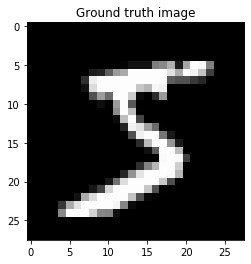

In [5]:


######### honest partipant #########
img_index = 0
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=10)


batch =100  #
for bat in range(batch-1):
    tmp = torch.unsqueeze(tp(dst[img_index+1+bat][0]).to(device),0)
    #print(tmp.shape)
    gt_data = torch.cat((gt_data,tmp),0)
    
    gt_label_tmp = torch.Tensor([dst[img_index+1+bat][1]]).long().to(device) #use img_index
   
    gt_label_tmp = gt_label_tmp.view(1, )
    gt_label = torch.cat((gt_label,gt_label_tmp),0)
    gt_onehot_label = torch.cat((gt_onehot_label,label_to_onehot(gt_label_tmp, num_classes=10)),0)

   
    #plt.savefig("./original/index_%s_label_%s"%(bat+1,gt_label_tmp.item()))
    
    #plt.title("Ground truth image")
    #print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    
gt_label = torch.reshape(gt_label,(-1,1))    
print (gt_data.shape)
print (gt_label.shape)
print (gt_onehot_label.shape)

plt.imshow(tt(gt_data[0].cpu()),cmap='gray')
plt.title("Ground truth image")
print("GT label is %d." % gt_label[0].item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label[0], dim=-1).item())

# compute original gradient 
dy_dx = []
original_dy_dx=[]
for item in range(batch):
    gt_data_single = torch.unsqueeze(gt_data[item],0)
    out = net(gt_data_single)
    #y = criterion(out, gt_onehot_label[item])
    y = criterion(out, gt_onehot_label[item])
    dy_dx = torch.autograd.grad(y, net.parameters())
    original_dy_dx_tmp = list((_.detach().clone() for _ in dy_dx))
    original_dy_dx.append(original_dy_dx_tmp)
   


# print (gt_data.shape)

# plt.imshow(tt(gt_data[0].cpu()),cmap='gray')
# plt.title("Ground truth image")
# print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# # compute original gradient 
# out = net(gt_data)
# y = criterion(out, gt_onehot_label)
# dy_dx = torch.autograd.grad(y, net.parameters())

# # share the gradients with other clients
# original_dy_dx = list((_.detach().clone() for _ in dy_dx))

In [13]:
# generate dummy data and label
import time
from pytorch_msssim import ssim

for item in range(1):
    start = time.time()
    for rd in range(1):

        torch.manual_seed(100*rd)
        #dummy_data = torch.unsqueeze(torch.randn(gt_data[item].size()),0).to(device).requires_grad_(True)
        
        #dummy_data = torch.unsqueeze(torch.zeros(gt_data[item].size()),0).to(device).requires_grad_(True)
        #dummy_data = torch.unsqueeze(torch.ones(gt_data[item].size()),0).to(device).requires_grad_(True)
        
        #surrogate = torch.unsqueeze(gt_data[item],0)
        #aaa = torch.rand([3,32,32])
        #surrogate[0,:,16:48,16:48] =aaa
        #dummy_data = surrogate.to(device).requires_grad_(True)
       
                
        k=np.random.randint(0,95)
        dummy_data = torch.unsqueeze(gt_data[k],0).to(device).requires_grad_(True)
        
        #aaa = torch.rand([1,14,14])
        #bbb = torch.cat((aaa,aaa),dim=1)
        #ccc = torch.cat((bbb,bbb),dim=2)
        #dummy_data = torch.unsqueeze(ccc,dim=0).to(device).requires_grad_(True)
        
        
        #dummy_data = plt.imread("./attack_image/replacement_69.png")
        #print (dummy_data.shape)
        #dummy_data = torch.FloatTensor(dummy_data).to(device)
        #dummy_data = dummy_data.transpose(2,3).transpose(1,2)
        
        #aaa = torch.rand([1,7,7])
        #bbb = torch.cat((aaa,aaa),dim=1)
        #ccc = torch.cat((bbb,bbb),dim=1)
        #ddd = torch.cat((ccc,ccc),dim=2)
        #eee = torch.cat((ddd,ddd),dim=2)
        #dummy_data = torch.unsqueeze(eee,dim=0).to(device).requires_grad_(True)
        
        
        
        dummy_label = torch.randn(gt_onehot_label[item].size()).to(device).requires_grad_(True)
        label_pred = torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)
        label_pred_onehot = label_to_onehot(label_pred, num_classes=10)
        
        plt.imshow(tt(dummy_data[0].cpu()))
        plt.title("Dummy data")
        #plt.savefig("./random_seed/index_%s_rand_seed_%s_label_%s"%(item,rd,torch.argmax(dummy_label, dim=-1).item()))

        plt.clf()
        print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        print("stolen label is %d." % label_pred.item())
        
        #optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
        optimizer = torch.optim.LBFGS([dummy_data,])
        
      

        history = []
        history_batch = []
        
        percept_dis = np.zeros(300)
        recover_dis = np.zeros(300)
        for iters in range(300):
            
            percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[item],dim=0),data_range=0).item()
            recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()
            
            history.append(tt(dummy_data[0].cpu()))
            def closure():
                optimizer.zero_grad()

                pred = net(dummy_data) 
                dummy_onehot_label = F.softmax(dummy_label, dim=-1)
                #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
             
                dummy_loss = criterion(pred, label_pred_onehot)
                
                dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                #dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                #print (dummy_dy_dp[0].shape)

                grad_diff = 0
                grad_count = 0
                #count =0
                for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here
                   
                    #if iters==500 or iters== 1200:
                    #    print (gx[0])
                    #    print ('hahaha')
                    #    print (gy[0])
                    lasso = torch.norm(dummy_data,p=1)
                    ridge = torch.norm(dummy_data,p=2)
                    grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge
                  

                    grad_count += gx.nelement()

                    #if count == 9:
                    #    break
                    #count=count+1
                # grad_diff = grad_diff / grad_count * 1000
                grad_diff.backward()
                #print (count)

                #print (dummy_dy_dx)
                #print (original_dy_dx)


                return grad_diff



            optimizer.step(closure)
            if iters % 5 == 0: 
                current_loss = closure()
                #if iters == 0: 
                #print ("%.8f" % current_loss.item())
                #print(iters, "%.8f" % current_loss.item())
            #history.append(tt(dummy_data[0].cpu()))

        
        
        #plt.figure(figsize=(18, 12))
        #for i in range(60):
        #   plt.subplot(6, 10, i + 1)
        #   plt.imshow(history[i * 5], cmap='gray')
        #   plt.title("iter=%d" % (i * 5))
        #   plt.axis('off')
            
        #np.savetxt('ssim_random2',percept_dis,fmt="%4f")
        #np.savetxt('mse_random2',recover_dis,fmt="%4f")
        
        #print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        #plt.savefig("./attack_image/mnist_index_%s_rand_%s_dummy_%s_label_%s"%(item,rd, torch.argmax(dummy_label, dim=-1).item(),label_pred.item()))
        #plt.clf()
       
    duration = time.time()-start
    #print ("Running time is %.4f." %(duration/10.0) )
    print (duration/10.0 )
    

/home/wenqi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Dummy label is 0.
stolen label is 5.
1.6254837000000009


/home/wenqi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


<Figure size 432x288 with 0 Axes>

In [73]:
# generate dummy data and label
# torch.manual_seed(55)
# aaa = torch.rand([1,14,14])
# bbb = torch.cat((aaa,aaa),dim=1)
# ccc = torch.cat((bbb,bbb),dim=2)
# dummy_data = torch.unsqueeze(ccc,dim=0).to(device).requires_grad_(True)


dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
label_pred = torch.argmin(torch.sum(original_dy_dx[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)

dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()),cmap='gray')
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
# print("stolen label is %d." % label_pred.item())

TypeError: sum() received an invalid combination of arguments - got (list, dim=int), but expected one of:
 * (Tensor input, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, tuple of names dim, bool keepdim, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, torch.dtype dtype, Tensor out)


In [ ]:
#optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )
optimizer = torch.optim.LBFGS([dummy_data,] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
       
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        
        label_pred_onehot = label_to_onehot(label_pred, num_classes=10)
        dummy_loss = criterion(pred, label_pred_onehot)
        #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
            
        
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

Dummy label is 7.


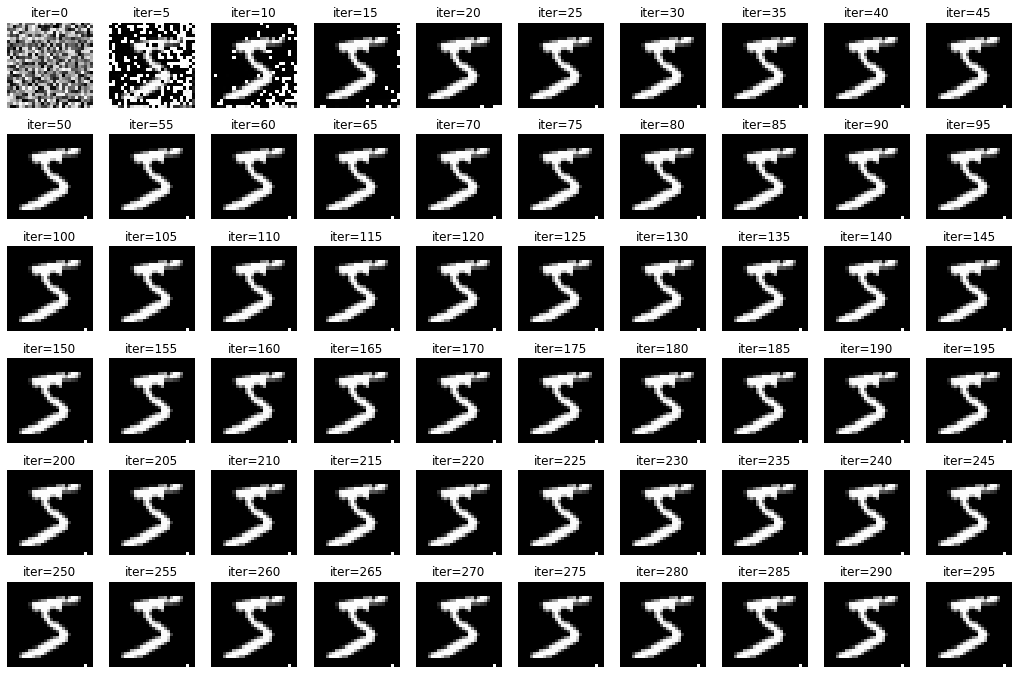

In [57]:
plt.figure(figsize=(18, 12))
for i in range(60):
  plt.subplot(6, 10, i + 1)
  plt.imshow(history[i * 5],cmap='gray')
  plt.title("iter=%d" % (i * 5))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())